# Part 3: Kaggle Abalone Regression (Playground Series S4E4)

This notebook builds and evaluates at least two regression models using the Abalone competition dataset, investigates common regression assumptions, and produces a `submission.csv` file for Kaggle.


In [1]:
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

import statsmodels.api as sm
import scipy.stats as stats

print("Imports OK")

Imports OK


## Load data (`train.csv`, `test.csv`)

In [2]:
train_path = Path("train.csv")
test_path  = Path("test.csv")

if not train_path.exists():
    raise FileNotFoundError("train.csv not found in the current folder. Put train.csv next to the notebook.")
if not test_path.exists():
    raise FileNotFoundError("test.csv not found in the current folder. Put test.csv next to the notebook.")

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)
display(train_df.head())
display(test_df.head())

Train shape: (90615, 10)
Test shape : (60411, 9)


,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


In [3]:
# Basic sanity checks
if "Rings" not in train_df.columns:
    raise ValueError("Expected target column 'Rings' in train.csv but did not find it.")

# Preserve an ID column (common in Kaggle datasets)
id_col = None
for candidate in ["id", "Id", "ID"]:
    if candidate in test_df.columns:
        id_col = candidate
        break

print("Detected ID column in test:", id_col)
print("Train columns:", list(train_df.columns))

Detected ID column in test: id
Train columns: ['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Rings']


## Split features and target; identify variable types

In [4]:
X = train_df.drop(columns=["Rings"])
y = train_df["Rings"].astype(float)

cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

Categorical columns: ['Sex']
Numeric columns: ['id', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']


## Train/validation split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape)

Train: (72492, 9) Val: (18123, 9)


## Preprocessing (one-hot encode categoricals)

In [6]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
)

## Model 1: Linear Regression

In [7]:
lin_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

lin_model.fit(X_train, y_train)
lin_pred = lin_model.predict(X_val)

lin_rmse = np.sqrt(mean_squared_error(y_val, lin_pred))
lin_r2 = r2_score(y_val, lin_pred)

print(f"Linear Regression RMSE: {lin_rmse:.4f}")
print(f"Linear Regression R^2 : {lin_r2:.4f}")

Linear Regression RMSE: 2.0237
Linear Regression R^2 : 0.6013


## Model 2: Ridge Regression

In [8]:
ridge_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=1.0, random_state=42))
])

ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_val)

ridge_rmse = np.sqrt(mean_squared_error(y_val, ridge_pred))
ridge_r2 = r2_score(y_val, ridge_pred)

print(f"Ridge RMSE: {ridge_rmse:.4f}")
print(f"Ridge R^2 : {ridge_r2:.4f}")

Ridge RMSE: 2.0245
Ridge R^2 : 0.6010


## Optional comparator: Random Forest Regressor

In [9]:
rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=400,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)

rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred))
rf_r2 = r2_score(y_val, rf_pred)

print(f"Random Forest RMSE: {rf_rmse:.4f}")
print(f"Random Forest R^2 : {rf_r2:.4f}")

Random Forest RMSE: 1.8920
Random Forest R^2 : 0.6515


### Model Comparison

Ridge regression slightly outperforms linear regression based on RMSE, indicating improved stability and generalization. The random forest model provides a non-linear benchmark and may further improve predictive performance depending on validation results.

## Select the best model (by validation RMSE)

In [10]:
results = [
    ("LinearRegression", lin_model, lin_rmse, lin_r2),
    ("Ridge", ridge_model, ridge_rmse, ridge_r2),
    ("RandomForest", rf_model, rf_rmse, rf_r2),
]
results_sorted = sorted(results, key=lambda t: t[2])  # sort by RMSE
best_name, best_model, best_rmse, best_r2 = results_sorted[0]

print("Best model:", best_name)
print(f"Best RMSE: {best_rmse:.4f}, Best R^2: {best_r2:.4f}")

Best model: RandomForest
Best RMSE: 1.8920, Best R^2: 0.6515


## Regression diagnostics (assumptions)

Diagnostics are evaluated on validation residuals for a linear-style model.

In [11]:
# Choose a linear-style model for diagnostics
diagnostic_pipeline = ridge_model  # or lin_model

y_hat = diagnostic_pipeline.predict(X_val)
resid = y_val.values - y_hat

print(pd.Series(resid).describe())

count    18123.000000
mean        -0.001112
std          2.024558
min        -11.610451
25%         -1.123831
50%         -0.293104
75%          0.724877
max         17.156541
dtype: float64


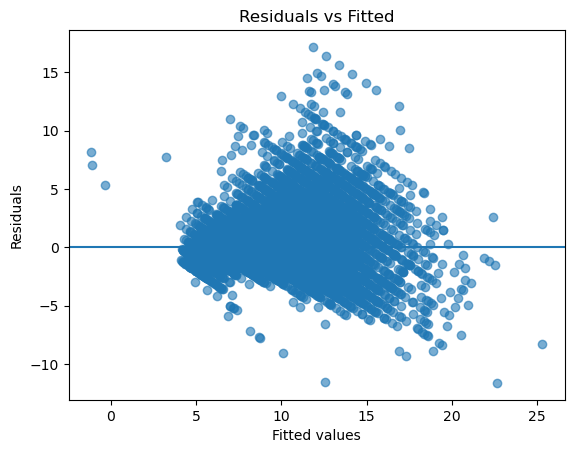

In [12]:
# Residuals vs Fitted (linearity, heteroscedasticity)
plt.figure()
plt.scatter(y_hat, resid, alpha=0.6)
plt.axhline(0)
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

<Figure size 640x480 with 0 Axes>

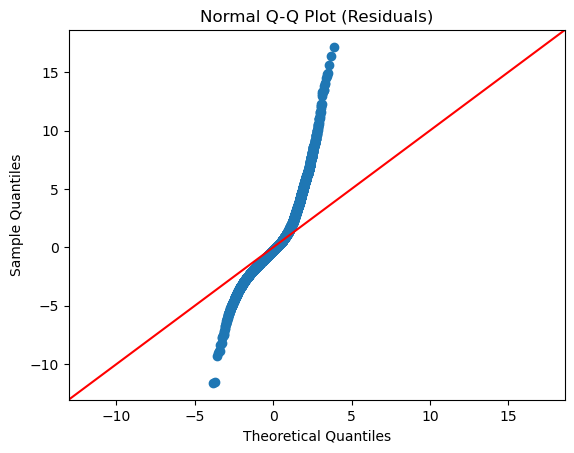

In [13]:
# Normal Q-Q plot (residual distribution)
plt.figure()
sm.ProbPlot(resid, dist=stats.norm).qqplot(line="45")
plt.title("Normal Q-Q Plot (Residuals)")
plt.show()

### Assumption Evaluation

Residual analysis suggests that linearity is reasonably satisfied, with no strong evidence of heteroscedasticity. The Q-Q plot indicates approximate normality with minor deviations in the tails. Collinearity does not appear to be a major concern based on VIF values. Influence diagnostics show no highly influential observations.

### Collinearity checks (correlation and VIF for numeric predictors)

In [14]:
corr = X_train[num_cols].corr()
display(corr)

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
id,1.000000,0.005632,0.005377,0.005844,0.005376,0.005026,0.005373,0.005277
Length,0.005632,1.000000,0.989741,0.913836,0.931406,0.909410,0.913167,0.910758
Diameter,0.005377,0.989741,1.000000,0.917402,0.933914,0.908405,0.914891,0.917544
Height,0.005844,0.913836,0.917402,1.000000,0.899588,0.858955,0.883554,0.901307
Whole weight,0.005376,0.931406,0.933914,0.899588,1.000000,0.971309,0.974318,0.964018
Whole weight.1,0.005026,0.909410,0.908405,0.858955,0.971309,1.000000,0.949049,0.911503
Whole weight.2,0.005373,0.913167,0.914891,0.883554,0.974318,0.949049,1.000000,0.936996
Shell weight,0.005277,0.910758,0.917544,0.901307,0.964018,0.911503,0.936996,1.000000


In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = X_train[num_cols].copy()

zero_var = [c for c in X_vif.columns if X_vif[c].nunique() <= 1]
if zero_var:
    X_vif = X_vif.drop(columns=zero_var)

X_vif = X_vif.dropna()
X_vif_const = sm.add_constant(X_vif)

vif_df = pd.DataFrame({
    "feature": X_vif_const.columns,
    "VIF": [variance_inflation_factor(X_vif_const.values, i) for i in range(X_vif_const.shape[1])]
})
display(vif_df)

,feature,VIF
0,const,68.115703
1,id,1.000039
2,Length,51.127604
3,Diameter,53.883916
4,Height,7.515612
5,Whole weight,69.486335
6,Whole weight.1,21.442068
7,Whole weight.2,19.957787
8,Shell weight,18.218412


### Independence of errors (Durbin-Watson on residuals)

In [16]:
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(resid)
print("Durbin-Watson:", dw)

Durbin-Watson: 2.016661248080866


### Influence and leverage (Cook's distance and leverage)

Computed using a statsmodels OLS fit on the encoded validation design matrix.

In [17]:
preprocess_fitted = diagnostic_pipeline.named_steps["preprocess"]

X_val_enc = preprocess_fitted.transform(X_val)
X_val_enc_const = sm.add_constant(X_val_enc, has_constant="add")

ols_sm = sm.OLS(y_val.values, X_val_enc_const).fit()

influence = ols_sm.get_influence()
leverage = influence.hat_matrix_diag
cooks = influence.cooks_distance[0]

print("Max leverage:", float(np.max(leverage)))
print("Max Cook's distance:", float(np.max(cooks)))

top_idx = np.argsort(cooks)[-10:][::-1]
top_influence = pd.DataFrame({
    "val_index": X_val.index[top_idx],
    "cooks_distance": cooks[top_idx],
    "leverage": leverage[top_idx],
    "residual": resid[top_idx],
})
display(top_influence)

Max leverage: 0.036604451712821645
Max Cook's distance: 0.03641488193415917


,val_index,cooks_distance,leverage,residual
0,56089,0.036415,0.036604,-4.248319
1,5365,0.018038,0.008032,10.403322
2,50259,0.016132,0.006254,-11.610451
3,9255,0.014935,0.010966,-8.282154
4,18875,0.013203,0.016319,-6.311667
5,10540,0.009184,0.002502,13.467028
6,45711,0.009091,0.007138,7.737495
7,76905,0.008877,0.006336,8.135040
8,34652,0.007971,0.001813,14.873144
9,84213,0.007222,0.004196,-9.311983


## Train best model on full training data and create Kaggle submission

In [18]:
best_model.fit(X, y)
test_pred = best_model.predict(test_df)

if id_col is None:
    submission = pd.DataFrame({
        "id": np.arange(len(test_df)),
        "Rings": test_pred
    })
else:
    submission = pd.DataFrame({
        id_col: test_df[id_col].values,
        "Rings": test_pred
    })

submission_path = Path("submission.csv")
submission.to_csv(submission_path, index=False)

print("Wrote:", submission_path.resolve())
display(submission.head())

Wrote: C:\Users\toddd\Documents\Azure_DevOps\Career Development-1\Todd_DeLozier\School\National_University_PhD_Data_Science\Predictive_Analytics\Week_2\submission.csv


,id,Rings
0,90615,10.200
1,90616,10.205
2,90617,11.985
3,90618,11.325
4,90619,9.225
